In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant packages and set up notebook
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from qubits import *

In [5]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt

import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
# FT_Device = params["UMA5"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

In [6]:
from typing import Dict, Any
import numpy as np
import qutip as qt
import scqubits as scq

class CoupledFT(Qubit):
    """
    Coupled Fluxonium-Transmon qubit class.
    
    Args:
        params (Dict): Dictionary of parameters defining the coupled system
    
    On init:
        - Builds scqubits objects for subsystems and HilbertSpace
        - Runs build_ops() to save operators in self.ops
        - Generates empty results dictionary self._eig_system 
    """
    
    expected_params = ["EJ_f", "EC_f", "EL_f", "flux", "cutoff_f", "truncated_dim_f",
                       "EJ_t", "EC_t", "ng_t", "ncut_t", "truncated_dim_t", "Jc"]

    def __init__(self, params: Dict[str, Any]):
        self.params = params.copy()
        
        # Set defaults
        if "flux" not in self.params:
            self.params["flux"] = 0.5
        if "ng_t" not in self.params:
            self.params["ng_t"] = 0.0
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = self.params["truncated_dim_f"] * self.params["truncated_dim_t"]
        
        super().__init__(self.params)
        self._eig_system = {}  # Initialize _eig_system
        
        self.build_scq_objects()
        self.build_ops()

    def build_scq_objects(self):
        self.fl = scq.Fluxonium(
            EJ=self.params["EJ_f"],
            EC=self.params["EC_f"],
            EL=self.params["EL_f"],
            flux=self.params["flux"],
            cutoff=self.params["cutoff_f"],
            truncated_dim=self.params["truncated_dim_f"]
        )
        self.tr = scq.Transmon(
            EJ=self.params["EJ_t"],
            EC=self.params["EC_t"],
            ng=self.params["ng_t"],
            ncut=self.params["ncut_t"],
            truncated_dim=self.params["truncated_dim_t"]
        )
        self.hspace = scq.HilbertSpace([self.fl, self.tr])
        self.hspace.add_interaction(
            g=self.params["Jc"],
            op1=(self.fl.n_operator, self.fl),
            op2=(self.tr.n_operator, self.tr)
        )
        self.hspace.generate_lookup()

    def build_ops(self):
        # Full product basis dimension (harmonic/charge basis)
        self.dim_harm = self.hspace.dim
        self.ops["Id_harm"] = qt.qeye(self.dim_harm)
        self.ops["Id"] = qt.qeye(self.params["N_max"])
        
        # Operators as Qobj in full product basis
        n_f_sparse = scq.identity_wrap(self.fl.n_operator(), self.fl, self.hspace.subsys_list)
        self.ops["n_f"] = qt.Qobj(n_f_sparse.tocoo())
        
        phi_f_sparse = scq.identity_wrap(self.fl.phi_operator(), self.fl, self.hspace.subsys_list)
        self.ops["phi_f"] = qt.Qobj(phi_f_sparse.tocoo())
        
        n_t_sparse = scq.identity_wrap(self.tr.n_operator(), self.tr, self.hspace.subsys_list)
        self.ops["n_t"] = qt.Qobj(n_t_sparse.tocoo())

    @property
    def phi_zpf(self):
        Ec = self.params["EC_f"]
        El = self.params["EL_f"]
        return (8 * Ec / El) ** (1/4) / np.sqrt(2)
    
    @property
    def n_zpf(self):
        Ec = self.params["EC_f"]
        El = self.params["EL_f"]
        return 1 / (np.sqrt(2) * (8 * Ec / El) ** (1/4))
    
    def get_H(self):
        ham_sparse = self.hspace.hamiltonian()
        return 2 * np.pi * qt.Qobj(ham_sparse.tocoo())

    @property
    def Ud(self):
        vecs = self._eig_system.get('vecs', [])
        if vecs:
            # Construct unitary with columns as eigenvectors (full basis)
            matrix = np.column_stack([v.full().flatten() for v in vecs])
            return qt.Qobj(matrix)
        return qt.Qobj()

    @property
    def H0(self):
        eigvals = self._eig_system.get('vals', [])
        if len(eigvals) > 0:
            eigvals = eigvals - eigvals[0]
        return qt.Qobj(np.diag(eigvals[:self.params["N_max"]]))

    def get_dressed_epairs(self, num_levels_f=4, num_levels_t=4):
        evals = self._eig_system.get('vals', [])
        ekets = self._eig_system.get('vecs', [])
        if not evals or not ekets:
            raise ValueError("Eigen system not computed yet.")
        
        dressed_epairs = np.empty((num_levels_f, num_levels_t), dtype=object)
        trunc_f = self.params["truncated_dim_f"]
        trunc_t = self.params["truncated_dim_t"]
        
        for i in range(num_levels_f):
            for j in range(num_levels_t):
                index = self.hspace.dressed_index((i, j))
                if index is not None and index < len(ekets):
                    bare_ket = qt.tensor(qt.basis(trunc_f, i), qt.basis(trunc_t, j))
                    ztemp = bare_ket.overlap(ekets[index])
                    phase_factor = np.exp(-1j * np.angle(ztemp))
                    dressed_epairs[i, j] = (evals[index], phase_factor * ekets[index])
        
        return dressed_epairs

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/scqubits/utils/misc.py: 236

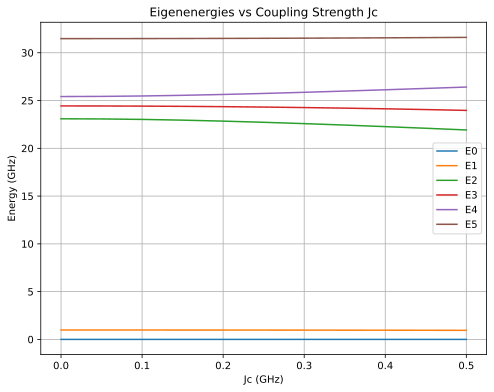

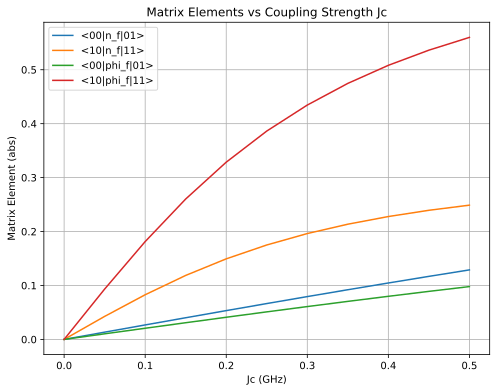

For Jc = 0:
Energies: [0.         0.15664788 3.67674941 3.89084822 4.0474961  5.01261606]
<00|n_f|01>: 0.0
<10|n_f|11>: 0.0
<00|phi_f|01>: 0.0
<10|phi_f|11>: 0.0

For Jc = 0.5:
Energies: [0.         0.15102358 3.49040577 3.81646042 4.20547835 5.03325564]
<00|n_f|01>: 0.1288774789057052
<10|n_f|11>: 0.24888938588161774
<00|phi_f|01>: 0.097925458118196
<10|phi_f|11>: 0.5599295955686645


In [17]:
import numpy as np
import qutip as qt
import scqubits as scq
import matplotlib.pyplot as plt
from typing import Dict, Any

# Assume Qubit base class is defined
class Qubit:
    def __init__(self, params: Dict[str, Any]):
        self.params = params
        self.ops = {}
        self._eig_system = {}

# CoupledFT class (with correction: use .dimension instead of .dim)
class CoupledFT(Qubit):
    expected_params = ["EJ_f", "EC_f", "EL_f", "flux", "cutoff_f", "truncated_dim_f",
                       "EJ_t", "EC_t", "ng_t", "ncut_t", "truncated_dim_t", "Jc"]

    def __init__(self, params: Dict[str, Any]):
        self.params = params.copy()
        if "flux" not in self.params:
            self.params["flux"] = 0.5
        if "ng_t" not in self.params:
            self.params["ng_t"] = 0.0
        if "N_max" not in self.params:
            self.params["N_max"] = self.params["truncated_dim_f"] * self.params["truncated_dim_t"]
        super().__init__(self.params)
        self._eig_system = {}
        self.build_scq_objects()
        self.build_ops()

    def build_scq_objects(self):
        self.fl = scq.Fluxonium(
            EJ=self.params["EJ_f"],
            EC=self.params["EC_f"],
            EL=self.params["EL_f"],
            flux=self.params["flux"],
            cutoff=self.params["cutoff_f"],
            truncated_dim=self.params["truncated_dim_f"]
        )
        self.tr = scq.Transmon(
            EJ=self.params["EJ_t"],
            EC=self.params["EC_t"],
            ng=self.params["ng_t"],
            ncut=self.params["ncut_t"],
            truncated_dim=self.params["truncated_dim_t"]
        )
        self.hspace = scq.HilbertSpace([self.fl, self.tr])
        self.hspace.add_interaction(
            g=self.params["Jc"],
            op1=(self.fl.n_operator, self.fl),
            op2=(self.tr.n_operator, self.tr)
        )
        self.hspace.generate_lookup()

    def build_ops(self):
        self.dim_harm = self.hspace.dimension  # Corrected from .dim to .dimension
        self.ops["Id_harm"] = qt.qeye(self.dim_harm)
        self.ops["Id"] = qt.qeye(self.params["N_max"])
        n_f_sparse = scq.identity_wrap(self.fl.n_operator(), self.fl, self.hspace.subsys_list)
        self.ops["n_f"] = qt.Qobj(n_f_sparse)
        
        phi_f_sparse = scq.identity_wrap(self.fl.phi_operator(), self.fl, self.hspace.subsys_list)
        self.ops["phi_f"] = qt.Qobj(phi_f_sparse)
        
        n_t_sparse = scq.identity_wrap(self.tr.n_operator(), self.tr, self.hspace.subsys_list)
        self.ops["n_t"] = qt.Qobj(n_t_sparse)

    @property
    def phi_zpf(self):
        Ec = self.params["EC_f"]
        El = self.params["EL_f"]
        return (8 * Ec / El) ** (1/4) / np.sqrt(2)
    
    @property
    def n_zpf(self):
        Ec = self.params["EC_f"]
        El = self.params["EL_f"]
        return 1 / (np.sqrt(2) * (8 * Ec / El) ** (1/4))
    
    def get_H(self):
        ham_sparse = self.hspace.hamiltonian()
        return 2 * np.pi * qt.Qobj(ham_sparse)

    @property
    def Ud(self):
        vecs = self._eig_system.get('vecs', [])
        if vecs:
            matrix = np.column_stack([v.full().flatten() for v in vecs])
            return qt.Qobj(matrix)
        return qt.Qobj()

    @property
    def H0(self):
        eigvals = self._eig_system.get('vals', [])
        if len(eigvals) > 0:
            eigvals = eigvals - eigvals[0]
        return qt.Qobj(np.diag(eigvals[:self.params["N_max"]]))

    def get_dressed_epairs(self, num_levels_f=4, num_levels_t=4):
        evals = self._eig_system.get('vals', [])
        ekets = self._eig_system.get('vecs', [])
        # if not evals or not ekets:
        #     raise ValueError("Eigen system not computed yet.")
        dressed_epairs = np.empty((num_levels_f, num_levels_t), dtype=object)
        trunc_f = self.params["truncated_dim_f"]
        trunc_t = self.params["truncated_dim_t"]
        for i in range(num_levels_f):
            for j in range(num_levels_t):
                index = self.hspace.dressed_index((i, j))
                if index is not None and index < len(ekets):
                    bare_ket = qt.tensor(qt.basis(trunc_f, i), qt.basis(trunc_t, j))
                    ztemp = bare_ket.overlap(ekets[index])
                    phase_factor = np.exp(-1j * np.angle(ztemp))
                    dressed_epairs[i, j] = (evals[index], phase_factor * ekets[index])
        return dressed_epairs

# Example parameters (fixed except Jc)
base_params = {
    "EJ_f": 3.73,
    "EC_f": 0.9,
    "EL_f": 0.36,
    "flux": 0.5,
    "cutoff_f": 50,
    "truncated_dim_f": 6,
    "EJ_t": 11.0,
    "EC_t": 0.19,
    "ng_t": 0.0,
    "ncut_t": 15,
    "truncated_dim_t": 6,
    "Jc": 0.0  # Placeholder, will vary
}

# Vary Jc from 0 to 0.5 GHz in 11 steps
jc_values = np.linspace(0, 0.5, 11)

# Lists to store results
energies = []  # Shape: (len(jc_values), num_levels)
mes_nf_00_01 = []
mes_nf_10_11 = []
mes_phif_00_01 = []
mes_phif_10_11 = []

for jc in jc_values:
    params = base_params.copy()
    params["Jc"] = jc
    coupled = CoupledFT(params)
    H = coupled.get_H()
    evals, ekets = H.eigenstates()
    coupled._eig_system = {'vals': evals, 'vecs': ekets}
    evals_norm = evals - evals[0]
    energies.append(evals_norm[:6])  # First 6 energies
    
    # Get dressed states
    dressed_epairs = coupled.get_dressed_epairs(num_levels_f=4, num_levels_t=4)
    
    # Matrix elements (absolute values)
    n_f = coupled.ops["n_f"]
    phi_f = coupled.ops["phi_f"]
    
    # <00|n_f|01>
    idx00 = coupled.hspace.dressed_index((0, 0))
    idx01 = coupled.hspace.dressed_index((0, 1))
    me_nf_00_01 = abs(ekets[idx00].dag() * n_f * ekets[idx01]) if idx00 is not None and idx01 is not None else 0
    mes_nf_00_01.append(me_nf_00_01)
    
    # <10|n_f|11>
    idx10 = coupled.hspace.dressed_index((1, 0))
    idx11 = coupled.hspace.dressed_index((1, 1))
    me_nf_10_11 = abs(ekets[idx10].dag() * n_f * ekets[idx11]) if idx10 is not None and idx11 is not None else 0
    mes_nf_10_11.append(me_nf_10_11)
    
    # <00|phi_f|01>
    me_phif_00_01 = abs(ekets[idx00].dag() * phi_f * ekets[idx01]) if idx00 is not None and idx01 is not None else 0
    mes_phif_00_01.append(me_phif_00_01)
    
    # <10|phi_f|11>
    me_phif_10_11 = abs(ekets[idx10].dag() * phi_f * ekets[idx11]) if idx10 is not None and idx11 is not None else 0
    mes_phif_10_11.append(me_phif_10_11)

# Convert to arrays
energies = np.array(energies)

# Plot energies vs Jc
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(jc_values, energies[:, i], label=f'E{i}')
plt.xlabel('Jc (GHz)')
plt.ylabel('Energy (GHz)')
plt.title('Eigenenergies vs Coupling Strength Jc')
plt.legend()
plt.grid(True)
plt.show()

# Plot matrix elements vs Jc
plt.figure(figsize=(8, 6))
plt.plot(jc_values, mes_nf_00_01, label='<00|n_f|01>')
plt.plot(jc_values, mes_nf_10_11, label='<10|n_f|11>')
plt.plot(jc_values, mes_phif_00_01, label='<00|phi_f|01>')
plt.plot(jc_values, mes_phif_10_11, label='<10|phi_f|11>')
plt.xlabel('Jc (GHz)')
plt.ylabel('Matrix Element (abs)')
plt.title('Matrix Elements vs Coupling Strength Jc')
plt.legend()
plt.grid(True)
plt.show()

# Print sample data for first and last Jc
print("For Jc = 0:")
print("Energies:", energies[0, :6]/6.28)
print("<00|n_f|01>:", mes_nf_00_01[0])
print("<10|n_f|11>:", mes_nf_10_11[0])
print("<00|phi_f|01>:", mes_phif_00_01[0])
print("<10|phi_f|11>:", mes_phif_10_11[0])

print("\nFor Jc = 0.5:")
print("Energies:", energies[-1, :6]/6.28)
print("<00|n_f|01>:", mes_nf_00_01[-1])
print("<10|n_f|11>:", mes_nf_10_11[-1])
print("<00|phi_f|01>:", mes_phif_00_01[-1])
print("<10|phi_f|11>:", mes_phif_10_11[-1])

In [ ]:
class DrivenQubit(DrivenSystem):
    """
    Driven qubit class for constructing Floquet Hamiltonian.

    Args:
        params (Dict): Dictionary of parameters defining the driven qubit
        qubit (Qubit): Bare quantum system (i.e. Transmon) object
        drive_coupling (qt.Qobj): Operator coupling to the drive. Note that 
                                  drive_coupling is NOT a composite operator
                                  and should have the dimension of the qubit.
    
    On init:
        - Runs build_ops_and_states()
        - Generates analysis dictionaries
    """
    expected_params = ["M_max"]
    
    # Build drive operators and states
    # ==========================================        
    def build_ops_and_states(self):
        """
        Method to construct drive operators in the extended Hilbert space.
        """
        M_max = self.params["M_max"]

        # Construct M = ∑ₘ m|m><m| operator in drive charge basis
        self.ops["M"] = qt.Qobj(np.diag(np.arange(-M_max, M_max + 1)))
        
        # Construct Id = ∑ₘ|m><m| in the drive charge basis
        self.ops["Id_drive"] = qt.Qobj(np.identity(2 * M_max + 1))

        # Construct M₊ and M₋ operators for drive
        self.ops["M-"] = qt.Qobj(np.eye(2 * M_max + 1, k=1))
        self.ops["M+"] = qt.Qobj(np.eye(2 * M_max + 1, k=-1))
        
        # Construct cos(θ) ≡ 1/2 * [M₊ + M₋] = 1/2 * ∑ₘ|m+1><m| + h.c
        self.ops["cos(θ)"] = 0.5 * (self.ops["M+"] + self.ops["M-"])

        # Construct |m=0⟩ Floquet mode, corresponding to zero drive photons.
        self.states["m=0"] = qt.basis(2 * M_max + 1, M_max)

        # Construct bare basis vectors and energies
        bare_eigvals, bare_eigvecs = self.qubit.H0.eigenstates()
        self.states["bare_basis"] = [qt.tensor(ev, self.states["m=0"]) for ev in bare_eigvecs]
        self.bare_energies = bare_eigvals
        
    
    # Effective Hamiltonian Definitions
    # ==========================================
    @property
    def H0(self):
        """
        Method to generate the bare system Hamiltonian H₀ ⊗ Id in the extended space
        """
        return qt.tensor(self.qubit.H0, self.ops["Id_drive"])
    
    @property
    def H_d(self):
        """
        Method to generate the operator part of the drive Hamiltonian H_d(t) in the extended 
        space. That is, for H_d(t) = Ω*Q*cos(ωt) and θ = ωt, we return Q ⊗ cos(θ). 
        
        Returns:
            Q ⊗ cos(θ) (qt.Qobj): Operator part of H_d; here Q is the drive_coupling.
        """
        return qt.tensor(self.ops["drive_coupling"], self.ops["cos(θ)"])
    
    def H_eff(self, omega: float, drive_amp: float):
        """
        Method to construct effective Hamiltonian H_eff = H₀ + H_d - i[∂/∂t] = H₀ + H_d + ωM
        in the extended space. 
        
        Args:
            omega (float): Drive frequency
            drive_amp (float): Drive amplitude 
        """
        M_composite = qt.tensor(self.qubit.ops["Id"], self.ops["M"])
        return self.H0 + (drive_amp * self.H_d) + (omega * M_composite)
    
    # Analysis
    # ==========================================
    def get_state_idxs(self, omega: float):
        """
        Method to get the indices of the basis states |α⟩⊗|m⟩ for all m, at zero drive amplitude
        Ω = 0. This is done by computing the closest energies to the known energies. 
        """
        M_max = self.params["M_max"]
        
        H_eff_0 = self.H_eff(omega, 0)
        eigvals, eigvecs = H_eff_0.eigenstates()

        idxs = {}
        for i, E in enumerate(self.bare_energies):
            for m in range(-M_max, M_max+1):
                idx_min = np.argmin(
                    [np.abs(E + m*omega - eigval) for eigval in eigvals]
                )
                idxs[(i, m)] = idx_min
                
        return idxs
    
    import numpy as np

    # Assuming this is added to your DrivenQubit class (self has access to bare_energies, params, H_eff)
    def get_state_idxs_tracked(self, omega: float, drive_amp: float, steps: np.ndarray):
        """
        Method to get the indices of the basis states |α⟩⊗|m⟩ for all m, at a given drive amplitude
        Ω ≠ 0, by tracking evolution step-by-step from amp=0.
        
        Args:
            omega: Drive frequency in GHz.
            drive_amp: Target drive amplitude in GHz.
            steps: Array of amplitude steps from 0 to drive_amp (inclusive).
        
        Returns:
            Dict[(int, int), int]: (alpha, m) -> index in eigstates at drive_amp.
        """
        M_max = self.params["M_max"]
        
        # Ensure steps include 0 and drive_amp, sorted ascending
        steps = np.unique(np.concatenate(([0, drive_amp], steps)))
        steps = np.sort(steps)
        
        # Step 1: Explicitly compute at amp=0 to get initial tracked energies (using your process)
        H_eff_0 = self.H_eff(omega, 0)
        evals_0, _ = H_eff_0.eigenstates()
        
        tracked_energies = {}
        for alpha, E_bare in enumerate(self.bare_energies):
            for m in range(-M_max, M_max + 1):
                diffs = np.abs([E_bare + m * omega - eval for eval in evals_0])
                idx_min = np.argmin(diffs)
                tracked_energies[(alpha, m)] = evals_0[idx_min]  # Use actual eval as starting point
        
        # Step 2: Track through remaining steps
        prev_evals = evals_0
        final_idxs = {}  # Will update at each step, return at end
        
        for amp in steps[1:]:  # Skip 0 since already done
            H_eff = self.H_eff(omega, amp)
            evals, _ = H_eff.eigenstates()
            
            for key, tracked_E in tracked_energies.items():
                diffs = np.abs(evals - tracked_E)
                idx_min = np.argmin(diffs)
                final_idxs[key] = idx_min
                # Update tracked energy for next step
                tracked_energies[key] = evals[idx_min]
            
            prev_evals = evals
        
        return final_idxs

At flux=0.5, dressed state labels:
E0: |0f0t> (overlap 1.00)
E1: |1f0t> (overlap 1.00)
E2: |2f0t> (overlap 1.00)
E3: |0f1t> (overlap 1.00)
E4: |1f1t> (overlap 1.00)
E5: |3f0t> (overlap 1.00)


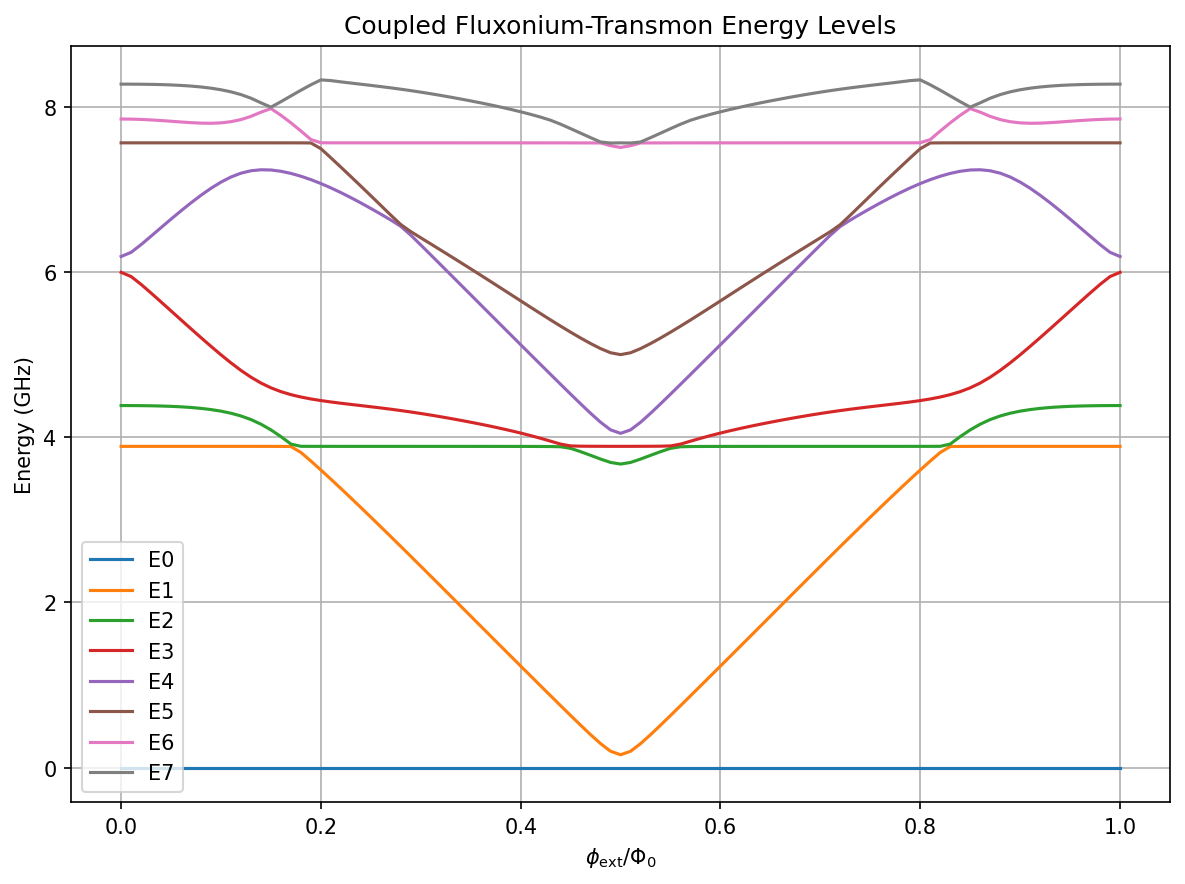

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

class CoupledFluxoniumTransmon:
    """
    Coupled fluxonium-transmon system class.
    
    Args:
        params (Dict): Dictionary of parameters for both qubits and coupling.
    """
    
    expected_params = ["Ec_f", "Ej_f", "El_f", "ng_f", "N_max_harm_f", "flux",
                       "Ec_t", "Ej_t", "ng_t", "N_charge_t", "Jc"]

    def __init__(self, params: dict):
        self.params = params.copy()
        self.params.setdefault("ng_f", 0.0)
        self.params.setdefault("ng_t", 0.0)
        self.params.setdefault("flux", 0.5)
        self.dim_f = self.params["N_max_harm_f"]
        self.dim_t = 2 * self.params["N_charge_t"] + 1
        self.build_ops()

    def build_ops(self):
        # Fluxonium operators (harmonic basis)
        Ec_f, El_f = self.params["Ec_f"], self.params["El_f"]
        phi_osc_f = (8 * Ec_f / El_f) ** 0.25
        a_f = qt.destroy(self.dim_f)
        self.phi_f = phi_osc_f * (a_f + a_f.dag()) / np.sqrt(2)
        self.n_f = 1j * (a_f.dag() - a_f) / (phi_osc_f * np.sqrt(2))
        self.Id_f = qt.qeye(self.dim_f)
        
        # Transmon operators (charge basis)
        N_t = self.params["N_charge_t"]
        self.n_t = qt.charge(N_t)
        self.cos_phi_t = qt.tunneling(self.dim_t) / 2
        self.Id_t = qt.qeye(self.dim_t)

    def build_cos_f(self):
        phi_ext = 2 * np.pi * self.params["flux"]
        arg = self.phi_f - phi_ext * self.Id_f
        return ((1j * arg).expm() + (-1j * arg).expm()) / 2

    def get_H_f(self):
        Ej_f, Ec_f, El_f, ng_f = self.params["Ej_f"], self.params["Ec_f"], self.params["El_f"], self.params["ng_f"]
        return (4 * Ec_f * (self.n_f - ng_f * self.Id_f)**2 +
                0.5 * El_f * self.phi_f**2 -
                Ej_f * self.build_cos_f())

    def get_H_t(self):
        Ej_t, Ec_t, ng_t = self.params["Ej_t"], self.params["Ec_t"], self.params["ng_t"]
        return (4 * Ec_t * (self.n_t - ng_t * self.Id_t)**2 -
                Ej_t * self.cos_phi_t)

    def get_H(self):
        H_f = self.get_H_f()
        H_t = self.get_H_t()
        H_int = self.params["Jc"] * qt.tensor(self.n_f, self.n_t)
        return qt.tensor(H_f, self.Id_t) + qt.tensor(self.Id_f, H_t) + H_int

    def get_dressed_labels(self, num_levels=6, max_bare_per=5):
        # Subsystem eigensystems
        evals_f, evecs_f = self.get_H_f().eigenstates()
        evals_t, evecs_t = self.get_H_t().eigenstates()
        
        # Bare product states
        bare_list = []
        for i in range(max_bare_per):
            for j in range(max_bare_per):
                en = evals_f[i] + evals_t[j]
                state = qt.tensor(evecs_f[i], evecs_t[j])
                label = f"|{i}f{j}t>"
                bare_list.append((en, label, state))
        
        min_en = min(en for en, _, _ in bare_list)
        bare_list = [(en - min_en, lab, st) for en, lab, st in bare_list]
        bare_list.sort(key=lambda x: x[0])
        
        # Dressed eigensystem
        evals, evecs = self.get_H().eigenstates()
        evals -= evals[0]
        
        labels = []
        for k in range(num_levels):
            psi = evecs[k]
            max_ol = 0
            best = "mixed"
            for _, lab, bst in bare_list:
                ol = abs(bst.dag() * psi) ** 2
                if ol > max_ol:
                    max_ol = ol
                    best = lab if ol > 0.5 else "mixed"
            labels.append((best, max_ol))
        return labels

# Parameters (example values)
params = {
    "Ec_f": 0.9, "Ej_f": 3.73, "El_f": 0.36, "ng_f": 0.0, "N_max_harm_f": 20,
    "Ec_t": 0.19, "Ej_t": 11.0, "ng_t": 0.0, "N_charge_t": 15,
    "Jc": 0.025  # Coupling strength in GHz
}

# Flux points
flux_values = np.linspace(0, 1, 101)

# List to store energies
energies = []

# Compute for each flux
for flux in flux_values:
    params["flux"] = flux
    coupled = CoupledFluxoniumTransmon(params)
    H = coupled.get_H()
    evals = H.eigenenergies()  # Faster for energies only
    normalized_energies = evals - evals[0]
    energies.append(normalized_energies[:9])  # First 6 levels
    
    # Label at flux=0.5
    if abs(flux - 0.5) < 1e-6:
        labels = coupled.get_dressed_labels()
        print("At flux=0.5, dressed state labels:")
        for idx, (lab, ol) in enumerate(labels):
            print(f"E{idx}: {lab} (overlap {ol:.2f})")

# Convert to array
energies = np.array(energies)

# Plot energy levels
plt.figure(figsize=(8, 6))
for i in range(8):
    plt.plot(flux_values, energies[:, i], label=f'E{i}')
plt.xlabel(r'$\phi_{\text{ext}}/\Phi_0$')
plt.ylabel('Energy (GHz)')
plt.title('Coupled Fluxonium-Transmon Energy Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('coupled_energy_levels.png')
plt.show()

In [10]:
import numpy as np
import qutip as qt

class CoupledFluxoniumTransmon:
    """
    Coupled fluxonium-transmon system class.
    
    Args:
        params (Dict): Dictionary of parameters for both qubits and coupling.
    """
    
    expected_params = ["Ec_f", "Ej_f", "El_f", "ng_f", "N_max_harm_f", "flux",
                       "Ec_t", "Ej_t", "ng_t", "N_charge_t", "Jc"]

    def __init__(self, params: dict):
        self.params = params.copy()
        self.params.setdefault("ng_f", 0.0)
        self.params.setdefault("ng_t", 0.0)
        self.params.setdefault("flux", 0.5)
        self.dim_f = self.params["N_max_harm_f"]
        self.dim_t = 2 * self.params["N_charge_t"] + 1
        self.build_ops()

    def build_ops(self):
        # Fluxonium operators (harmonic basis)
        Ec_f, El_f = self.params["Ec_f"], self.params["El_f"]
        phi_osc_f = (8 * Ec_f / El_f) ** 0.25
        a_f = qt.destroy(self.dim_f)
        self.phi_f = phi_osc_f * (a_f + a_f.dag()) / np.sqrt(2)
        self.n_f = 1j * (a_f.dag() - a_f) / (phi_osc_f * np.sqrt(2))
        self.Id_f = qt.qeye(self.dim_f)
        
        # Transmon operators (charge basis)
        N_t = self.params["N_charge_t"]
        self.n_t = qt.charge(N_t)
        dim = self.dim_t
        off_diag = np.diag(0.5 * np.ones(dim - 1), 1) + np.diag(0.5 * np.ones(dim - 1), -1)
        self.cos_phi_t = qt.Qobj(off_diag)
        self.Id_t = qt.qeye(self.dim_t)

    def build_cos_f(self):
        phi_ext = 2 * np.pi * self.params["flux"]
        arg = self.phi_f - phi_ext * self.Id_f
        return ((1j * arg).expm() + (-1j * arg).expm()) / 2

    def get_H_f(self):
        Ej_f, Ec_f, El_f, ng_f = self.params["Ej_f"], self.params["Ec_f"], self.params["El_f"], self.params["ng_f"]
        return (4 * Ec_f * (self.n_f - ng_f * self.Id_f)**2 +
                0.5 * El_f * self.phi_f**2 -
                Ej_f * self.build_cos_f())

    def get_H_t(self):
        Ej_t, Ec_t, ng_t = self.params["Ej_t"], self.params["Ec_t"], self.params["ng_t"]
        return (4 * Ec_t * (self.n_t - ng_t * self.Id_t)**2 -
                Ej_t * self.cos_phi_t)

    def get_H(self):
        H_f = self.get_H_f()
        H_t = self.get_H_t()
        H_int = self.params["Jc"] * qt.tensor(self.n_f, self.n_t)
        return qt.tensor(H_f, self.Id_t) + qt.tensor(self.Id_f, H_t) + H_int

    def get_dressed_decompositions(self, num_levels=6, max_bare_per=5, threshold=0.01):
        # Subsystem eigensystems
        evals_f, evecs_f = self.get_H_f().eigenstates()
        evals_t, evecs_t = self.get_H_t().eigenstates()
        
        # Dressed eigensystem
        evals_d, evecs_d = self.get_H().eigenstates()
        evals_d -= evals_d[0]
        
        decomps = []
        for k in range(num_levels):
            psi = evecs_d[k]
            components = {}
            for i in range(max_bare_per):
                for j in range(max_bare_per):
                    bst = qt.tensor(evecs_f[i], evecs_t[j])
                    ol = abs(bst.dag() * psi) ** 2
                    if ol >= threshold:
                        lab = f"|{i}f{j}t>"
                        components[lab] = ol
            sorted_comp = dict(sorted(components.items(), key=lambda item: item[1], reverse=True))
            decomps.append((evals_d[k], sorted_comp))
        return decomps

    def get_matrix_elements(self, num_levels=6):
        n_f_full = qt.tensor(self.n_f, self.Id_t)
        phi_f_full = qt.tensor(self.phi_f, self.Id_t)
        n_t_full = qt.tensor(self.Id_f, self.n_t)
        
        ops = {'n_f': n_f_full, 'phi_f': phi_f_full, 'n_t': n_t_full}
        
        _, evecs_d = self.get_H().eigenstates()
        
        mes = {}
        for op_name, op in ops.items():
            mes[op_name] = {}
            for i in range(num_levels):
                for j in range(i+1, num_levels):
                    me = abs(evecs_d[i].dag() * op * evecs_d[j])
                    mes[op_name][f'{i}-{j}'] = me
        return mes

# Parameters
params = {
    "Ec_f": 0.9, "Ej_f": 3.73, "El_f": 0.36, "ng_f": 0.0, "N_max_harm_f": 20,
    "Ec_t": 0.19, "Ej_t": 11.0, "ng_t": 0.0, "N_charge_t": 15,
    "Jc": 0.025
}

params["flux"] = 0.5
coupled = CoupledFluxoniumTransmon(params)

decomps = coupled.get_dressed_decompositions()

print("Dressed states at flux=0.5:")
for idx, (energy, comp) in enumerate(decomps):
    print(f"E{idx}: {energy:.4f} GHz")
    print("Bare state decompositions (overlap > 0.01):")
    for lab, ol in comp.items():
        print(f"  {lab}: {ol:.4f}")
    print()

mes = coupled.get_matrix_elements()

print("Matrix elements in dressed basis:")
for op_name, me_dict in mes.items():
    print(f"Operator: {op_name}")
    for label in sorted(me_dict, key=lambda x: (int(x.split('-')[0]), int(x.split('-')[1]))):
        me = me_dict[label]
        print(f"  |<{label}|{op_name}|>: {me:.4f}")
    print()

Dressed states at flux=0.5:
E0: 0.0000 GHz
Bare state decompositions (overlap > 0.01):
  |0f0t>: 1.0000

E1: 0.1566 GHz
Bare state decompositions (overlap > 0.01):
  |1f0t>: 1.0000

E2: 3.6746 GHz
Bare state decompositions (overlap > 0.01):
  |2f0t>: 0.9982

E3: 3.8887 GHz
Bare state decompositions (overlap > 0.01):
  |0f1t>: 0.9998

E4: 4.0461 GHz
Bare state decompositions (overlap > 0.01):
  |1f1t>: 0.9982

E5: 4.9986 GHz
Bare state decompositions (overlap > 0.01):
  |3f0t>: 0.9998

Matrix elements in dressed basis:
Operator: n_f
  |<0-1|n_f|>: 0.0588
  |<0-2|n_f|>: 0.0000
  |<0-3|n_f|>: 0.0068
  |<0-4|n_f|>: 0.0000
  |<0-5|n_f|>: 0.4862
  |<1-2|n_f|>: 0.5504
  |<1-3|n_f|>: 0.0000
  |<1-4|n_f|>: 0.0215
  |<1-5|n_f|>: 0.0000
  |<2-3|n_f|>: 0.0042
  |<2-4|n_f|>: 0.0000
  |<2-5|n_f|>: 0.4285
  |<3-4|n_f|>: 0.0590
  |<3-5|n_f|>: 0.0000
  |<4-5|n_f|>: 0.0163

Operator: phi_f
  |<0-1|phi_f|>: 2.7037
  |<0-2|phi_f|>: 0.0000
  |<0-3|phi_f|>: 0.0053
  |<0-4|phi_f|>: 0.0000
  |<0-5|phi_f|>: 0.

In [11]:
import numpy as np
import qutip as qt

class CoupledFluxoniumTransmon:
    """
    Coupled fluxonium-transmon system class.
    
    Args:
        params (Dict): Dictionary of parameters for both qubits and coupling.
    """
    
    expected_params = ["Ec_f", "Ej_f", "El_f", "ng_f", "N_max_harm_f", "flux",
                       "Ec_t", "Ej_t", "ng_t", "N_charge_t", "Jc"]

    def __init__(self, params: dict):
        self.params = params.copy()
        self.params.setdefault("ng_f", 0.0)
        self.params.setdefault("ng_t", 0.0)
        self.params.setdefault("flux", 0.5)
        self.dim_f = self.params["N_max_harm_f"]
        self.dim_t = 2 * self.params["N_charge_t"] + 1
        self.build_ops()

    def build_ops(self):
        # Fluxonium operators (harmonic basis)
        Ec_f, El_f = self.params["Ec_f"], self.params["El_f"]
        phi_osc_f = (8 * Ec_f / El_f) ** 0.25
        a_f = qt.destroy(self.dim_f)
        self.phi_f = phi_osc_f * (a_f + a_f.dag()) / np.sqrt(2)
        self.n_f = 1j * (a_f.dag() - a_f) / (phi_osc_f * np.sqrt(2))
        self.Id_f = qt.qeye(self.dim_f)
        
        # Transmon operators (charge basis)
        N_t = self.params["N_charge_t"]
        self.n_t = qt.charge(N_t)
        self.cos_phi_t = qt.tunneling(self.dim_t) / 2
        self.Id_t = qt.qeye(self.dim_t)

    def build_cos_f(self):
        phi_ext = 2 * np.pi * self.params["flux"]
        arg = self.phi_f - phi_ext * self.Id_f
        return ((1j * arg).expm() + (-1j * arg).expm()) / 2

    def get_H_f(self):
        Ej_f, Ec_f, El_f, ng_f = self.params["Ej_f"], self.params["Ec_f"], self.params["El_f"], self.params["ng_f"]
        return (4 * Ec_f * (self.n_f - ng_f * self.Id_f)**2 +
                0.5 * El_f * self.phi_f**2 -
                Ej_f * self.build_cos_f())

    def get_H_t(self):
        Ej_t, Ec_t, ng_t = self.params["Ej_t"], self.params["Ec_t"], self.params["ng_t"]
        return (4 * Ec_t * (self.n_t - ng_t * self.Id_t)**2 -
                Ej_t * self.cos_phi_t)

    def get_H(self):
        H_f = self.get_H_f()
        H_t = self.get_H_t()
        H_int = self.params["Jc"] * qt.tensor(self.n_f, self.n_t)
        return qt.tensor(H_f, self.Id_t) + qt.tensor(self.Id_f, H_t) + H_int

    def get_dressed_labels(self, num_levels=6, max_bare_per=5):
        # Subsystem eigensystems
        evals_f, evecs_f = self.get_H_f().eigenstates()
        evals_t, evecs_t = self.get_H_t().eigenstates()
        
        # Bare product states
        bare_list = []
        for i in range(max_bare_per):
            for j in range(max_bare_per):
                en = evals_f[i] + evals_t[j]
                state = qt.tensor(evecs_f[i], evecs_t[j])
                label = f"|{i}f{j}t>"
                bare_list.append((en, label, state))
        
        min_en = min(en for en, _, _ in bare_list)
        bare_list = [(en - min_en, lab, st) for en, lab, st in bare_list]
        bare_list.sort(key=lambda x: x[0])
        
        # Dressed eigensystem
        evals, evecs = self.get_H().eigenstates(sparse=True, eigvals=num_levels)
        evals -= evals[0]
        
        labels = []
        overlaps = []
        for k in range(num_levels):
            psi = evecs[k]
            max_ol = 0
            best = "mixed"
            for _, lab, bst in bare_list:
                ol = abs(bst.dag() * psi) ** 2
                if ol > max_ol:
                    max_ol = ol
                    best = lab if ol > 0.5 else "mixed"
            labels.append(best)
            overlaps.append(max_ol)
        return labels, overlaps

    def get_indirect_matrix_elements(self, num_levels=6):
        n_f_full = qt.tensor(self.n_f, self.Id_t)
        phi_f_full = qt.tensor(self.phi_f, self.Id_t)
        
        ops = {'n_f': n_f_full, 'phi_f': phi_f_full}
        
        labels, _ = self.get_dressed_labels(num_levels=num_levels)
        
        label_to_index = {lab: idx for idx, lab in enumerate(labels) if lab != "mixed"}
        
        pairs = [
            ('|0f0t>', '|0f1t>', 'n_f'),
            ('|1f0t>', '|1f1t>', 'n_f'),
            ('|0f0t>', '|0f1t>', 'phi_f'),
            ('|1f0t>', '|1f1t>', 'phi_f')
        ]
        
        evals, evecs = self.get_H().eigenstates(sparse=True, eigvals=num_levels)
        
        mes = {}
        for i0, i1, op_name in pairs:
            if i0 in label_to_index and i1 in label_to_index:
                idx0 = label_to_index[i0]
                idx1 = label_to_index[i1]
                if idx0 > idx1:
                    idx0, idx1 = idx1, idx0
                op = ops[op_name]
                me = abs(evecs[idx0].dag() * op * evecs[idx1])
                key = f'<{i0[1:-1]}|{op_name}|{i1[1:-1]}>'
                mes[key] = me
            else:
                mes[key] = 'Label not found or mixed'
        
        return mes

# Parameters
params = {
    "Ec_f": 0.9, "Ej_f": 3.73, "El_f": 0.36, "ng_f": 0.0, "N_max_harm_f": 20,
    "Ec_t": 0.3, "Ej_t": 15.0, "ng_t": 0.0, "N_charge_t": 15,
    "Jc": 0.025
}

params["flux"] = 0.5
coupled = CoupledFluxoniumTransmon(params)

indirect_mes = coupled.get_indirect_matrix_elements()

print("Indirect matrix elements in dressed basis at flux=0.5:")
for key, value in indirect_mes.items():
    print(f"{key}: {value}")

Indirect matrix elements in dressed basis at flux=0.5:
<0f0t|n_f|0f1t>: 0.008784396015599709
<1f0t|n_f|1f1t>: 0.002214395993496168
<0f0t|phi_f|0f1t>: 0.015906528446026528
<1f0t|phi_f|1f1t>: 0.00759143885511355
